# Longitudinal LiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import lingam
from lingam.utils import make_dot

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.16.2', '0.24.2', '0.11.1', '1.3']


## Test data
We create test data consisting of 5 variables. The causal model at each timepoint is as follows.

In [2]:
# setting
n_features = 5
n_samples = 200
n_lags = 1
n_timepoints = 3

causal_orders = []
B_t_true = np.empty((n_timepoints, n_features, n_features))
B_tau_true = np.empty((n_timepoints, n_lags, n_features, n_features))
X_t = np.empty((n_timepoints, n_samples, n_features))

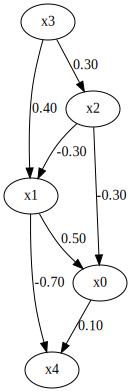

In [3]:
# B(0,0)
B_t_true[0] = np.array([[0.0, 0.5,-0.3, 0.0, 0.0],
                        [0.0, 0.0,-0.3, 0.4, 0.0],
                        [0.0, 0.0, 0.0, 0.3, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.1,-0.7, 0.0, 0.0, 0.0]])
causal_orders.append([3, 2, 1, 0, 4])
make_dot(B_t_true[0])

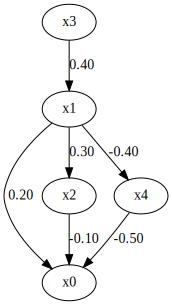

In [4]:
# B(1,1)
B_t_true[1] = np.array([[0.0, 0.2,-0.1, 0.0,-0.5],
                        [0.0, 0.0, 0.0, 0.4, 0.0],
                        [0.0, 0.3, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0,-0.4, 0.0, 0.0, 0.0]])
causal_orders.append([3, 1, 2, 4, 0])
make_dot(B_t_true[1])

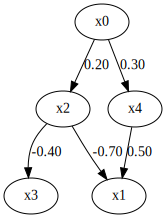

In [5]:
# B(2,2)
B_t_true[2] = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0,-0.7, 0.0, 0.5],
                        [0.2, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0,-0.4, 0.0, 0.0],
                        [0.3, 0.0, 0.0, 0.0, 0.0]])
causal_orders.append([0, 2, 4, 3, 1])
make_dot(B_t_true[2])

In [6]:
# create B(t,t-τ) and X
for t in range(n_timepoints):
    # external influence
    expon = 0.1
    ext = np.empty((n_features, n_samples))
    for i in range(n_features):
        ext[i, :] = np.random.normal(size=(1, n_samples));
        ext[i, :] = np.multiply(np.sign(ext[i, :]), abs(ext[i, :]) ** expon);
        ext[i, :] = ext[i, :] - np.mean(ext[i, :]);
        ext[i, :] = ext[i, :] / np.std(ext[i, :]);

    # create B(t,t-τ)
    for tau in range(n_lags):
        value = np.random.uniform(low=0.01, high=0.5, size=(n_features, n_features))
        sign = np.random.choice([-1, 1], size=(n_features, n_features))
        B_tau_true[t, tau] = np.multiply(value, sign)

    # create X(t)
    X = np.zeros((n_features, n_samples))
    for co in causal_orders[t]:
        X[co] = np.dot(B_t_true[t][co, :], X) + ext[co]
        if t > 0:
            for tau in range(n_lags):
                X[co] = X[co] + np.dot(B_tau_true[t, tau][co, :], X_t[t-(tau+1)].T)
    
    X_t[t] = X.T

## Causal Discovery
To run causal discovery, we create a `LongitudinalLiNGAM` object by specifying the `n_lags` parameter. Then, we call the `fit` method. 

In [8]:
model = lingam.LongitudinalLiNGAM(n_lags=n_lags)
model = model.fit(X_t)

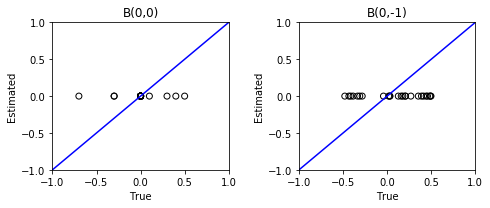

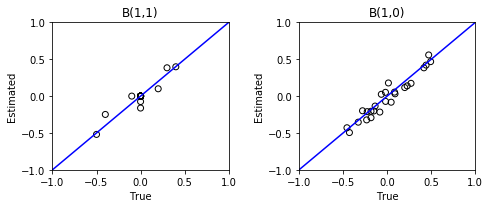

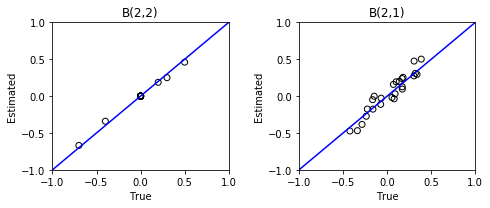

In [9]:
for t in range(n_timepoints):
    B_t, B_tau = model.adjacency_matrices_[t]
    plt.figure(figsize=(7, 3))

    plt.subplot(1,2,1)
    plt.plot([-1, 1],[-1, 1], marker="", color="blue", label="support")
    plt.scatter(B_t_true[t], B_t, facecolors='none', edgecolors='black')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.title(f'B({t},{t})')

    plt.subplot(1,2,2)
    plt.plot([-1, 1],[-1, 1], marker="", color="blue", label="support")
    plt.scatter(B_tau_true[t], B_tau, facecolors='none', edgecolors='black')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.title(f'B({t},{t-1})')

    plt.tight_layout()
    plt.show()